In [37]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
def pendulum_rhs(zt, dzt, coefficients, terms):
    d2z = []
    for i in range(len(zt)):
        theta = np.array([term(zt[i], dzt[i]) for term in terms])
        d2zi = np.dot(theta.T, coefficients)
        d2z.append(d2zi)

    return np.array(d2z)

In [101]:

def pendulum_rhs(zt, dzt, coefficients, terms):
    # If zt and dzt are scalars, handle it directly
    if np.isscalar(zt) and np.isscalar(dzt):
        theta = np.array([term(zt, dzt) for term in terms])
        return np.dot(theta, coefficients)  # Scalar result
    
    # Otherwise, if zt and dzt are vectors (arrays)
    else:
        d2z = []
        for i in range(len(zt)):
            theta = np.array([term(zt[i], dzt[i]) for term in terms])
            d2zi = np.dot(theta.T, coefficients)
            d2z.append(d2zi)
        return np.array(d2z)
    """"
def pendulum_rhs(zt, dzt, coefficients, terms):
    # If zt and dzt are scalars, handle it directly
    if np.isscalar(zt) and np.isscalar(dzt):
        theta = np.array([term(zt, dzt) for term in terms])
        return np.dot(theta, coefficients)  # Scalar result

    # Otherwise, if zt and dzt are vectors (arrays)
    else:
        # Compute theta for each time step in the vectors
        theta = np.array([np.array([term(z, dz) for term in terms]) for z, dz in zip(zt, dzt)])
        
        # Now, dot product can be performed for each time step
        d2z = np.dot(theta, coefficients)
        return d2z  # Returns an array of size T
        """
    
def pendulum_ode_step(y, t, coefficients, terms):
    z, dz = y
    d2z = pendulum_rhs(z,dz, coefficients, terms)
    dydt = [dz,d2z]
    return dydt


def simulate_pendulum(z0, dz0, coefficients, terms, T, dt):
    t = np.arange(0, T, dt)  # Time points
    y0 = z0, dz0
    result = odeint(pendulum_ode_step, y0, t, args=(coefficients,terms))
    return t, result

def create_pendulum_data(z0_min, z0_max, dz0_min, dz0_max, coefficients, terms, T,
dt, N, embedding = None, rejection = True):
    dataset = []
    while len(dataset) < N:
        z0 = np.random.uniform(z0_min, z0_max)
        dz0 = np.random.uniform(dz0_min, dz0_max)
        
        # Compute angular momentum condition
        energy = 0.5 * dz0**2 - np.cos(z0)
        if rejection and abs(energy) > 0.99:
            continue  # Reject the sample
        
        # Simulate the pendulum
        t, trajectory = simulate_pendulum(z0, dz0, coefficients, terms, T, dt)
        
        # Apply embedding if specified
        if embedding:
            trajectory = embedding(trajectory)
        
        dataset.append(trajectory)
    
    return dataset


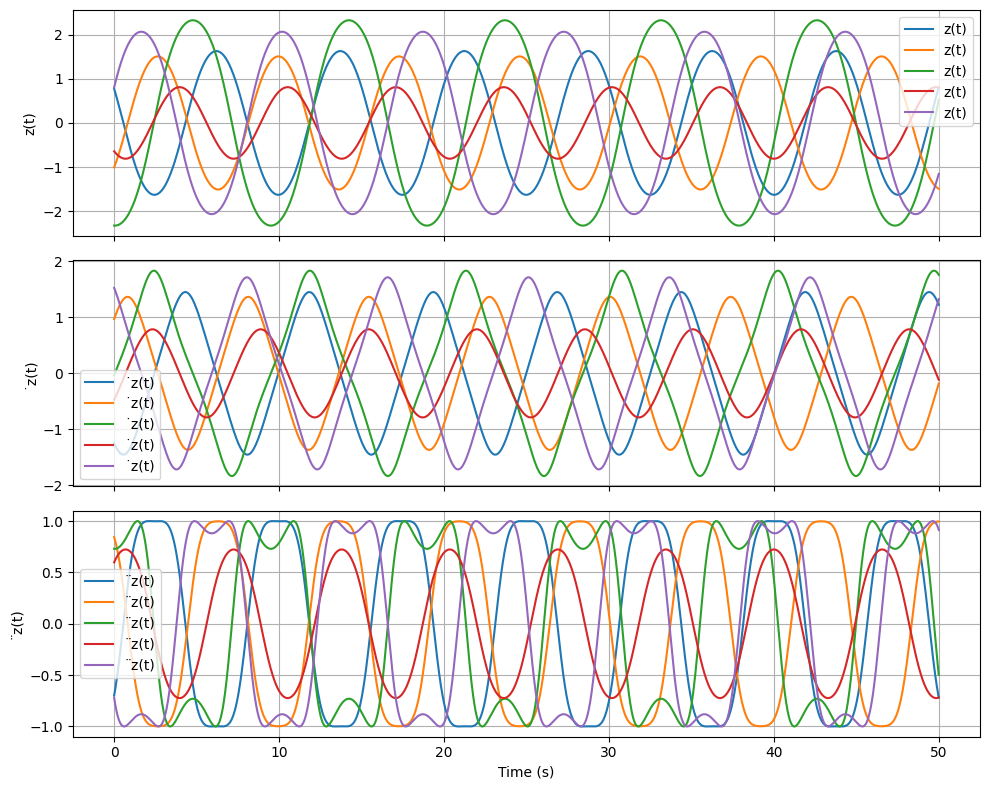

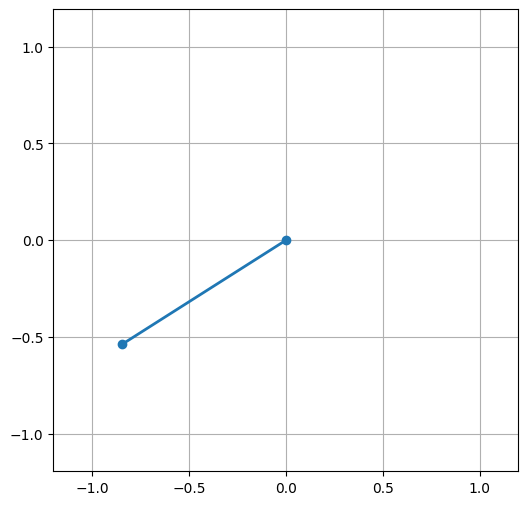

In [102]:
z0_min, z0_max = -np.pi, np.pi
dz0_min, dz0_max = -2.1, 2.1
T, dt, N = 50, 0.02, 100

terms = [
        lambda z, dz: np.sin(z) # -sin(z)
]

coefficients = np.array([-1])

dataset = create_pendulum_data(z0_min, z0_max,dz0_min, dz0_max, coefficients, terms, T, dt, N )
# Time array
time = np.arange(0, T, dt)

# Select 5 simulations to visualize
selected_simulations = dataset[:5]

# Plot z_t, ˙z_t, and ¨z_t for the selected simulations
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

for trajectory in selected_simulations:
    zt = trajectory[:, 0]        # z(t)
    dzt = trajectory[:, 1]       # ˙z(t)
    ddzt = pendulum_rhs(zt, dzt, coefficients, terms)  # ¨z(t)
    
    axes[0].plot(time, zt, label="z(t)")
    axes[1].plot(time, dzt, label="˙z(t)")
    axes[2].plot(time, ddzt, label="¨z(t)")

# Set axis labels
axes[0].set_ylabel("z(t)")
axes[1].set_ylabel("˙z(t)")
axes[2].set_ylabel("¨z(t)")
axes[2].set_xlabel("Time (s)")

# Add grid and legend
for ax in axes:
    ax.grid(True)
axes[0].legend()
axes[1].legend()
axes[2].legend()

plt.tight_layout()
plt.show()

# Optional: Animate the pendulum motion
def animate_pendulum(trajectory):
    zt = trajectory[:, 0]  # Extract z(t)
    x1 = np.sin(zt)        # x-coordinate of the mass
    x2 = -np.cos(zt)       # y-coordinate of the mass

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid()

    # Plot the pendulum
    line, = ax.plot([], [], 'o-', lw=2)  # Pendulum arm and mass

    def update(frame):
        # Update pendulum position for frame
        line.set_data([0, x1[frame]], [0, x2[frame]])  
        return line,

    ani = FuncAnimation(
        fig, update, frames=len(zt), blit=True, interval=dt *1000
    )
    
    plt.show()

animate_pendulum(selected_simulations[1])

## Exercise 2

In [175]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


#term library given in exercise (from prior knowledge)
terms = [
    lambda z, dz: 1,            # 1
    lambda z, dz: z,            # z
    lambda z, dz: dz,           # ˙z
    lambda z, dz: np.sin(z),    # sin(z)
    lambda z, dz: z**2,         # z^2
    lambda z, dz: z * dz,       # z · ˙z
    lambda z, dz: z * np.sin(z),# z · sin(z)
    lambda z, dz: dz**2,        # ˙z^2
    lambda z, dz: dz * np.sin(z), # ˙z · sin(z)
    lambda z, dz: np.sin(z)**2  # sin(z)^2
]

coefficients = np.random.normal(0,1,10)

#We need to obtain the second derivative for z for the simulaied pendulum:
data = dataset[0] #shape (T, 2)
z, dz = data[:,0], data[:,1]  #both shape (T,)

d2z = pendulum_rhs(z, dz, coefficients, terms) #shape (T,)

X = np.array([np.array([term(zt, dzt) for term in terms]) for zt, dzt in zip(z, dz)]) #design matrix 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X.shape)

l = 0.05 #coefficient for l1-regularization 
LasReg = Lasso(alpha=l)
LasReg.fit(X_scaled,d2z)
print(LasReg.coef_)
d2z_pred = LasReg.predict(X_scaled)
are_close = np.allclose(d2z, d2z_pred,atol=1)
print(are_close)

(2500, 10)
[ 0.         -1.21580743  0.59113258 -0.29858575 -0.         -0.
 -0.          0.         -0.34211462 -0.04340377]
True


Learned coefficients: [ 0.         -0.          0.68341775  0.         -0.07757968  0.
 -0.          0.          0.63670732 -0.        ]
Are the predicted d2z values close to the actual d2z values? True


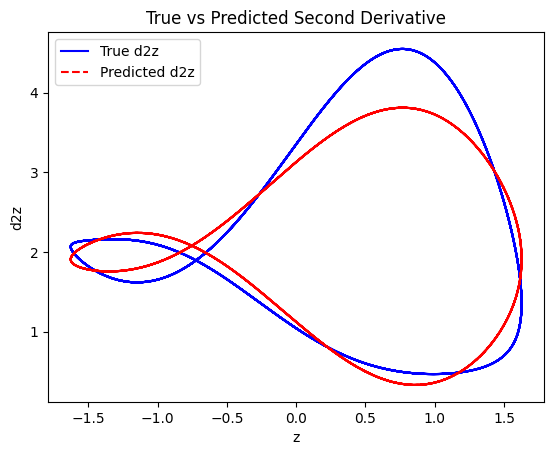

In [174]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Assuming pendulum_rhs, dataset, terms, and coefficients are already defined

# Simulated data (example)
data = dataset[0]  # Assuming dataset is available
z, dz = data[:, 0], data[:, 1]  # Both shape (T,)

# Compute the second derivative (d2z)
d2z = pendulum_rhs(z, dz, coefficients, terms)  # Shape (T,)

# Create the design matrix X (T, 10)
X = np.array([np.array([term(zt, dzt) for term in terms]) for zt, dzt in zip(z, dz)])

# Scale the design matrix (important for Lasso)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set alpha for Lasso (regularization strength)
l = 0.1 # Regularization parameter
LasReg = Lasso(alpha=l)

# Fit the Lasso model
LasReg.fit(X_scaled, d2z)

# Print the learned coefficients
print("Learned coefficients:", LasReg.coef_)

# Predict using the trained model
d2z_pred = LasReg.predict(X_scaled)

# Check if predictions are close to actual values
are_close = np.allclose(d2z, d2z_pred, atol=2)
print(f"Are the predicted d2z values close to the actual d2z values? {are_close}")

# Visualize the true vs. predicted second derivatives
plt.plot(z, d2z, label="True d2z", color='blue')
plt.plot(z, d2z_pred, label="Predicted d2z", color='red', linestyle='dashed')
plt.legend()
plt.xlabel('z')
plt.ylabel('d2z')
plt.title('True vs Predicted Second Derivative')
plt.show()
